<a href="https://colab.research.google.com/github/Deurru/AISaturdaysProject/blob/master/ToxicityFlairCorpus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toxicity Classifier using LSTM and Zalando´s Flair

### 01 - Basic start operations:
Mount the GDrive structure containing the datasets, import and install all libraries we are going to use to work on data,  check if hardware accelerator is activated.

In [6]:
# Mount Google Drive (On every new session)

import os

from google.colab import drive

drive.mount("/content/drive/")

# Change wordking directory to drive/My Drive, to access its contents easily
os.chdir("drive/My Drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [1]:
# installs flair library
!pip install flair

     |████████████████████████████████| 81kB 5.5MB/s 
     |████████████████████████████████| 798kB 15.1MB/s 
     |████████████████████████████████| 133kB 49.6MB/s 
     |████████████████████████████████| 1.0MB 40.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/70/55/6b/c12cf58209b8346f653a04f37dd8f607ab0e85a26238a23420
  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
  Stored in directory: /root/.cache/pip/wheels/bd/57/d3/907c3ee02d35e66f674ad0106e61f06eeeb98f6ee66a6cc3fe
Successfully built flair segtok mpld3 sqlitedict


In [0]:
# # Main imports here
import torch
import flair
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# version checks (not mandatory)
print(torch.__version__)
print(flair.__version__)

1.1.0
0.4.1


In [4]:
# checking for cuda (if false = GPU not activated. Go to Runtime > Change Runtime Type > Hardware Accelerator > Select "GPU")
print(torch.cuda.is_available())
print(torch.version.cuda)

True
10.0.130


In [7]:
# directory & dataset unzipping statements. Execute once, then comment.
!pwd # Checks working directory
# !unzip Datasets/jigsaw_unintended_bias_in_toxicity_classification.zip -d Datasets

/content/drive/My Drive


## 02 - Basic Data Exploration

In [0]:
# define path to source file and load data into pandas dataframe
train_path = "./Datasets/train.csv"
test_path = "./Datasets/test.csv"
trainset = pd.read_csv(train_path)
testset = pd.read_csv(test_path)

In [9]:
# check shape, column names and basic stats of attributes of dataset
# trainset
print(trainset.shape)
print(trainset.columns)
print(trainset.describe())
# testset
print(testset.shape)
print(testset.columns)
print(testset.describe())

(1804874, 45)
Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')
                 id  ...  toxicity_annotator_count
count  1.804874e+06  ...              1.804874e+06
mean   3.738434e+06  ...              8.784694e+00
std    2.445187e+06  ...              4.350086

In [10]:
trainset.head()

id    target  ... identity_annotator_count  toxicity_annotator_count
0  59848  0.000000  ...                        0                         4
1  59849  0.000000  ...                        0                         4
2  59852  0.000000  ...                        0                         4
3  59855  0.000000  ...                        0                         4
4  59856  0.893617  ...                        4                        47

[5 rows x 45 columns]

In [11]:
trainset.tail()

id    target  ... identity_annotator_count  toxicity_annotator_count
1804869  6333967  0.000000  ...                        0                         4
1804870  6333969  0.000000  ...                        0                         4
1804871  6333982  0.000000  ...                        0                         4
1804872  6334009  0.621212  ...                        0                        66
1804873  6334010  0.000000  ...                        0                         4

[5 rows x 45 columns]

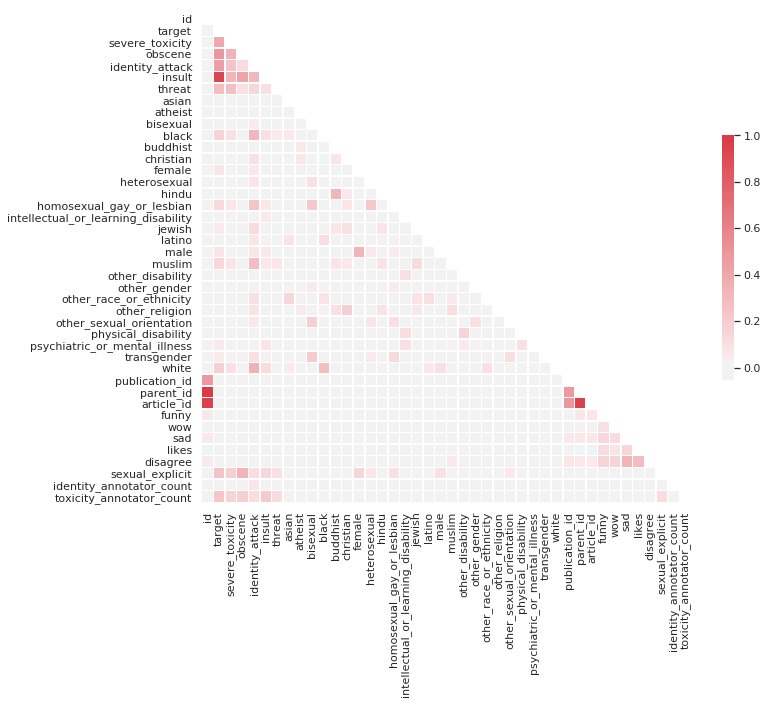

In [19]:
# Basic correlation matrix to quickly visualize data,
# using seaborn and matplotlib
# Credit: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# sns.set(style="white")
# Computes correlation matrix
corr = trainset.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)

mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

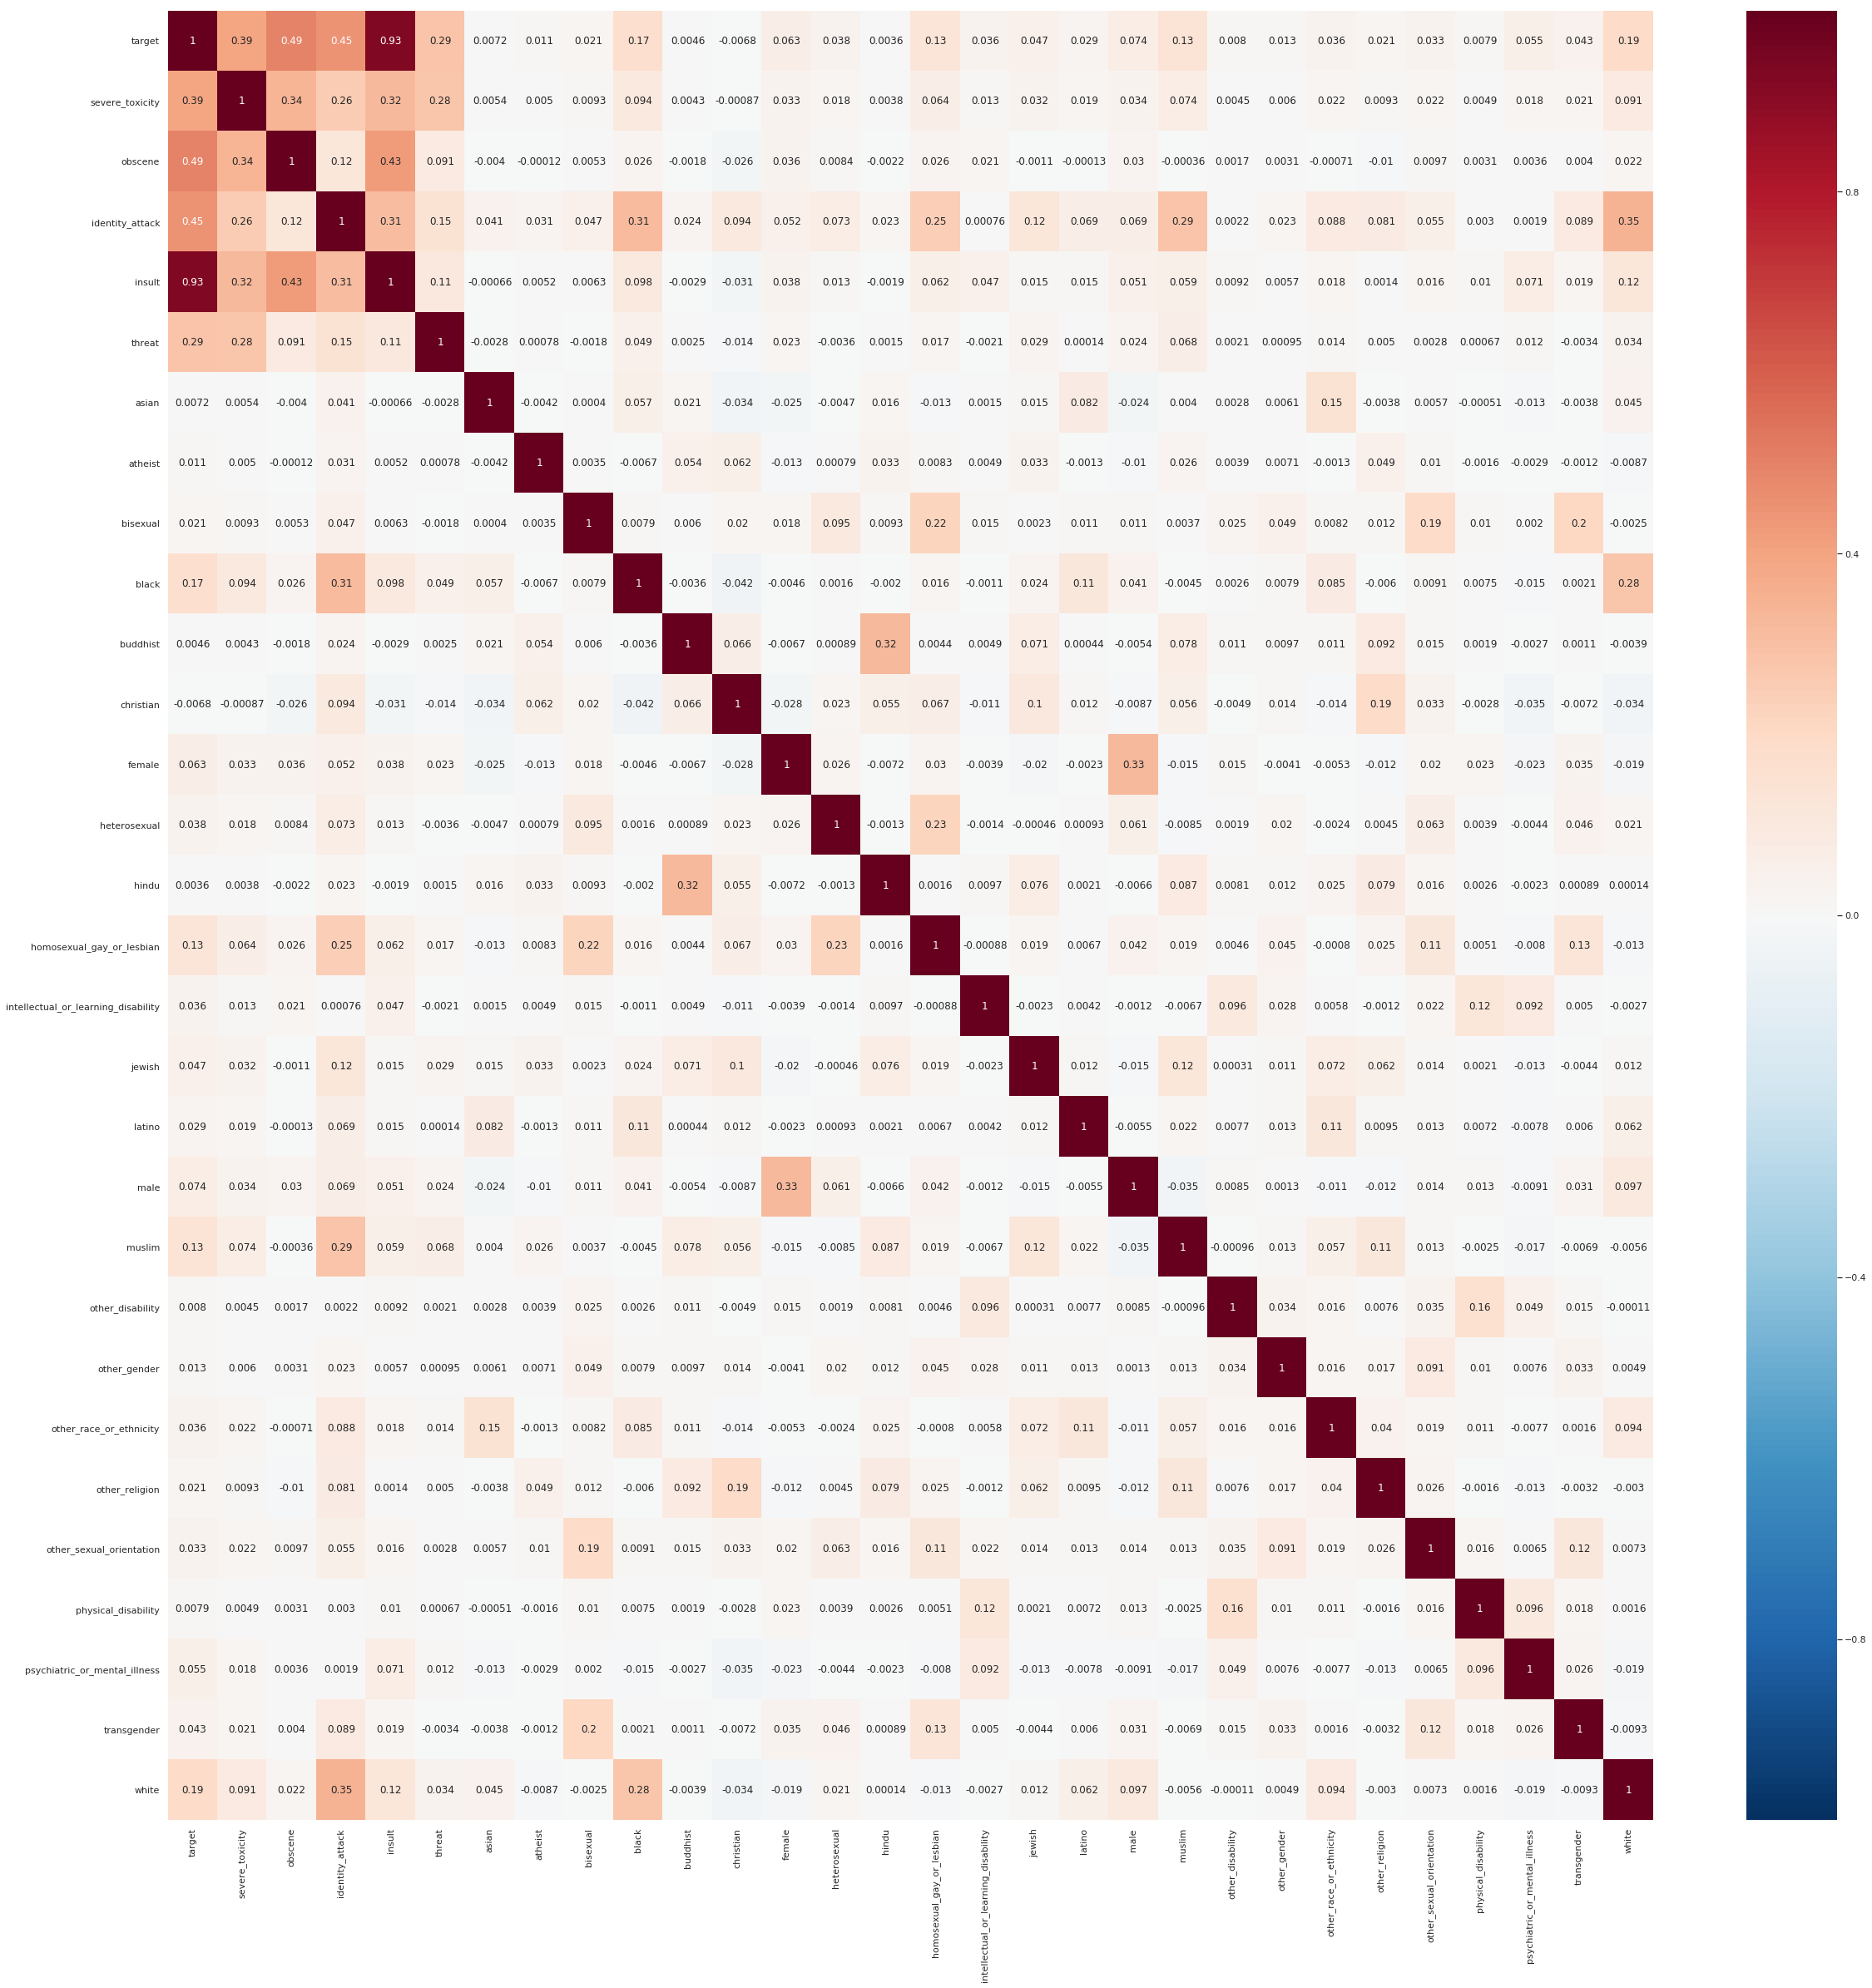

In [74]:
# subsetting those categories apparently correlated with toxicity,
# for further detail

train_subset = trainset.loc[:, ['target', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white']]

subset_corr = train_subset.corr()

plt.figure(figsize=(40, 40))

sns.heatmap(subset_corr, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

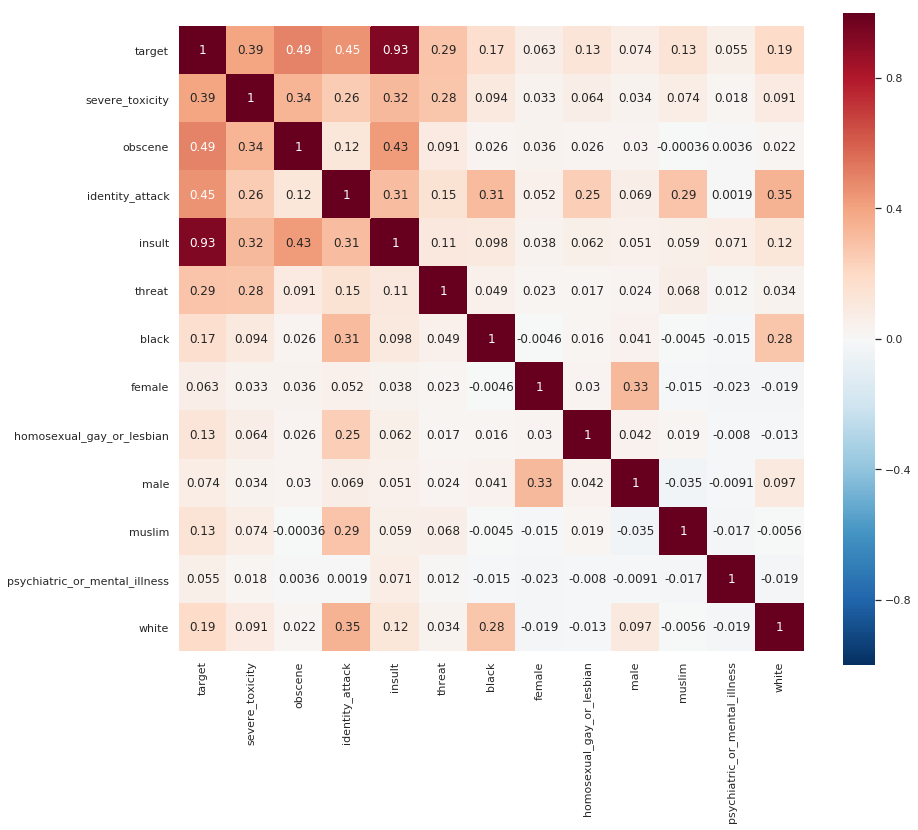

In [76]:
#Select subset of categories where correlation is higher than 0.05
subset_max = subset_corr.loc[subset_corr['target'] >= 0.05, subset_corr['target'] >= 0.05]

plt.figure(figsize=(14, 12))

sns.heatmap(subset_max, square=True, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

In [104]:
# show number and % of toxic comments in the dataset
# Checks number of NaN values per column.

toxic_comms= len(trainset[trainset['target'] >= 0.5])
toxic_comms_pctg = toxic_comms/len(trainset)*100
print(f"Nr. Toxic Commentaries = {toxic_comms}\n% of Toxic Comments = {toxic_comms_pctg: .2f}")

Nr. Toxic Commentaries = 144334
% of Toxic Comments =  8.00


In [109]:
toxic_list = []
for i in trainset['target']:
  if trainset[trainset['target'] >= 0.5]:
    toxic_list.append(trainset['id'])
#     df1.A.loc[lambda s: s > 0]


ValueError: ignored

In [106]:
toxic_list

[0          59848  
 1          59849  
 2          59852  
 3          59855  
 4          59856  
 5          59859  
 6          59861  
 7          59863  
 8          239575 
 9          239576 
 10         239578 
 11         239579 
 12         239582 
 13         239583 
 14         239584 
 15         239585 
 16         239589 
 17         239590 
 18         239591 
 19         239592 
 20         239593 
 21         239594 
 22         239596 
 23         239597 
 24         239598 
 25         239600 
 26         239602 
 27         239603 
 28         239604 
 29         239605 
             ...   
 1804844    6333888
 1804845    6333889
 1804846    6333893
 1804847    6333895
 1804848    6333897
 1804849    6333900
 1804850    6333907
 1804851    6333913
 1804852    6333915
 1804853    6333917
 1804854    6333919
 1804855    6333920
 1804856    6333923
 1804857    6333927
 1804858    6333928
 1804859    6333932
 1804860    6333933
 1804861    6333941
 1804862    6333947


In [90]:
# Showing toxic comment sample
# 196789
import textwrap
pd.set_option("display.max_colwidth", -1)
row_id = 196789
comm_id, tox_score, comment_text, sevtox_score, obs_score, id_score, ins_score, th_score, date, likes, disag, se_score = trainset_clean.loc[row_id]
comment_info = (f"Text: {textwrap.fill(comment_text, 100)}\nScoring:\nToxicity = {tox_score}\nObscenity = {obs_score}\nIdentity attack = {id_score}\nInsult = {ins_score}\nThreat = {th_score}\nExplicit Sex = {se_score}")
print(comment_info)

Text: Well, at least the Russians are white, for heaven's sakes.  I'd rather have to live next to a nice
white drunk Russian than a black Muslim Kenyan whose children's names are Satanic anagrams.
Scoring:
Toxicity = 1.0
Obscenity = 0.2
Identity attack = 1.0
Insult = 0.9
Threat = 0.0
Explicit Sex = 0.0


### 03 - Cleaning the Dataset
Dropping columns we do not need for the type of training we are going to choose, eliminating NaNs, normalizing variables, removing outliers (scores too high, texts too long, etc.).

####Dropping non relevant columns

In [0]:
# Drops non relevant columns: Creates a list of labels, then passes that list 
# to .drop() for the columns with those labels to be dropped from the dataframe

droplist = ['asian', 'atheist', 'bisexual','black', 'buddhist', 'christian',
            'female', 'heterosexual', 'hindu','homosexual_gay_or_lesbian',
            'intellectual_or_learning_disability',
            'jewish', 'latino', 'male', 'muslim', 'other_disability',
            'other_gender', 'other_race_or_ethnicity', 'other_religion',
            'other_sexual_orientation', 'physical_disability',
            'psychiatric_or_mental_illness', 'transgender', 'white',
            'publication_id', 'parent_id', 'article_id', 'rating', 'funny',
            'wow','sad', 'identity_annotator_count', 'toxicity_annotator_count']
trainset_clean = trainset.drop(columns = droplist)

In [22]:
print(trainset_clean.shape)
trainset_clean.columns

(1804874, 12)


Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'created_date', 'likes',
       'disagree', 'sexual_explicit'],
      dtype='object')

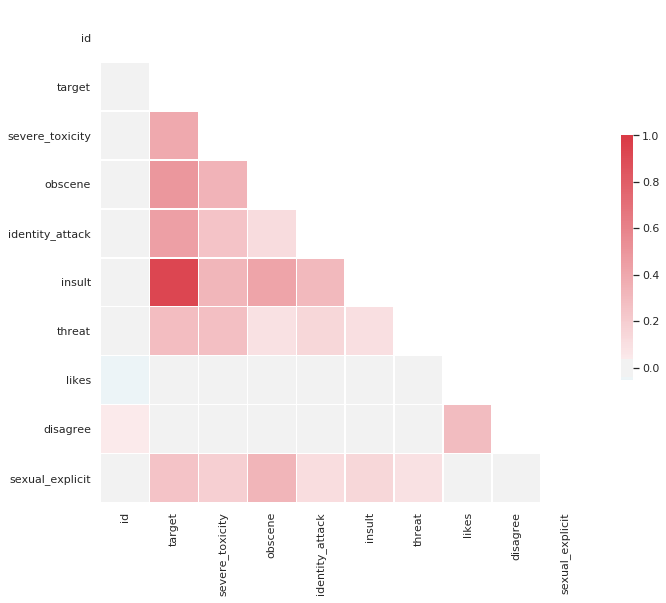

In [26]:
#Plot the new dataset again

corr_clean = trainset_clean.corr()

mask = np.zeros_like(corr_clean, dtype=np.bool)

mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_clean, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

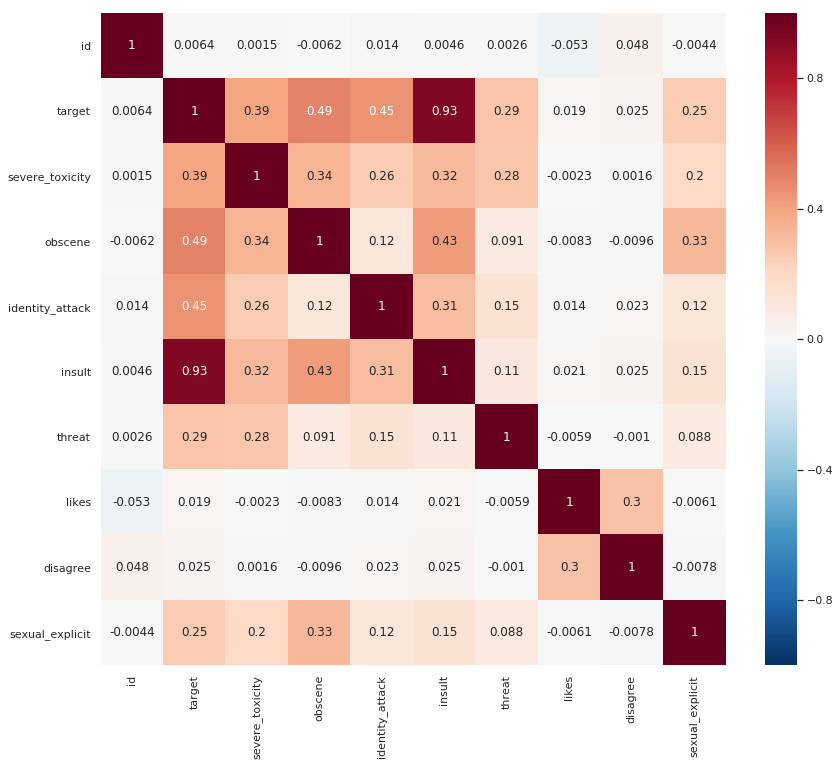

In [48]:
# n*n matrix, showing darker color according to direct correlation between variables.
# correlation = trainset_clean.corr()
# #display(correlation)
plt.figure(figsize=(14, 12))
# import seaborn as sns
sns.heatmap(corr_clean, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6a6a45780>,
      dtype=object)

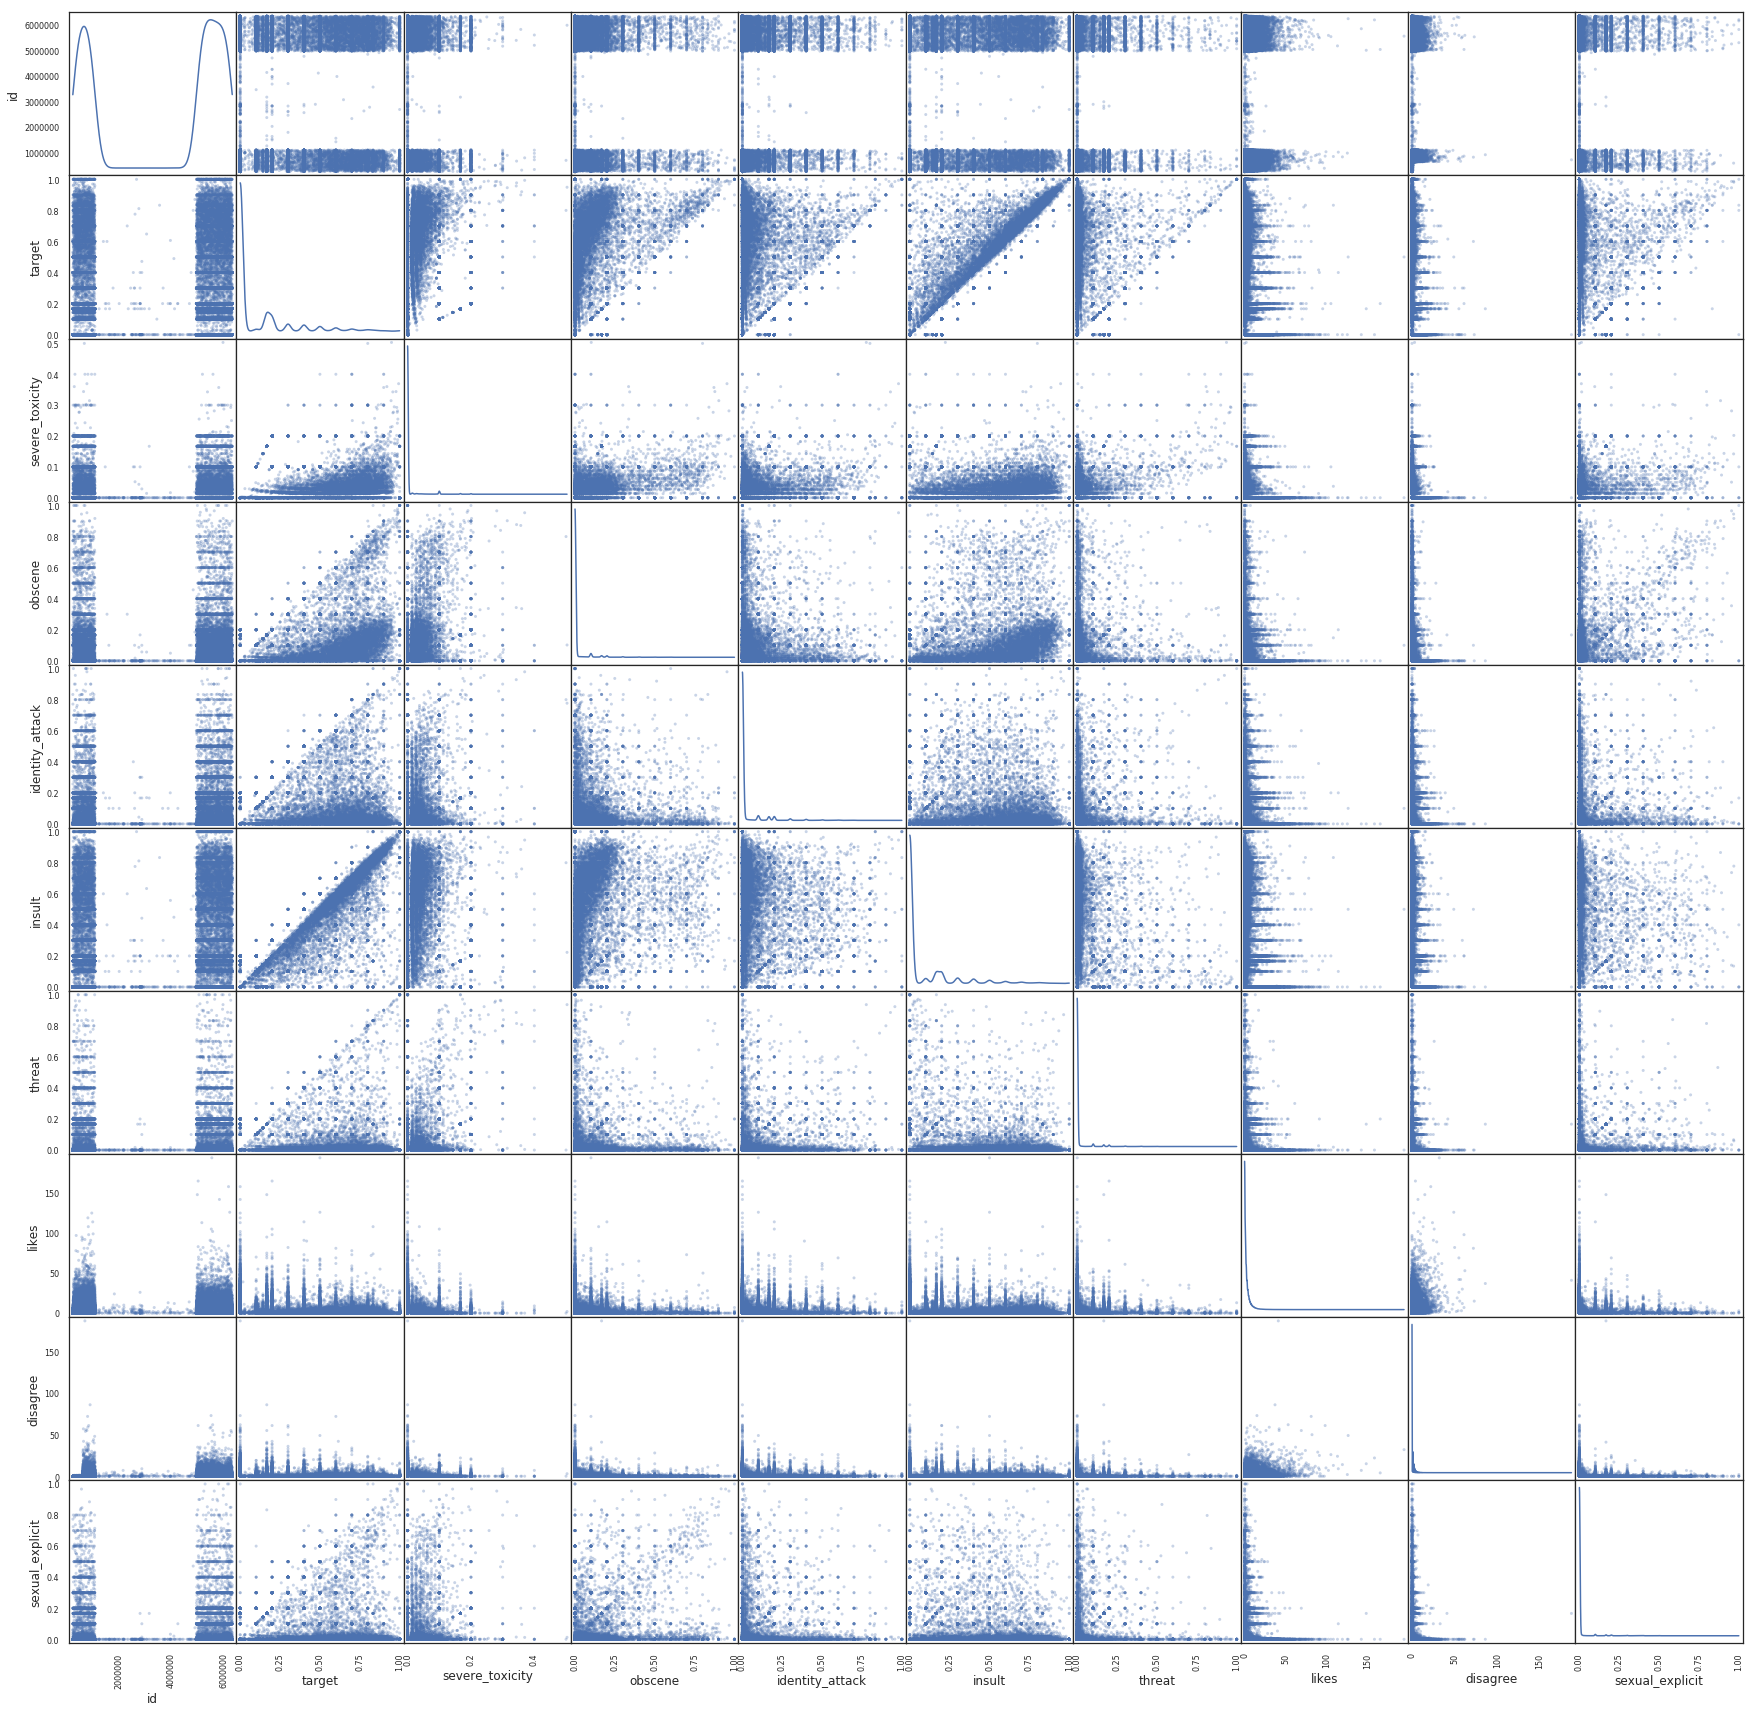

In [110]:
# Use pandas scatter_matrix to plot all correlations (random 200K registers)
plot_sample = trainset_clean.sample(n=200000)
pd.plotting.scatter_matrix(plot_sample, alpha = 0.3, figsize = (30,30), diagonal = 'kde')

####Cleaning/correcting empty values
Find categories with no info, correcting if possible, discarding if not.

In [35]:
# Checks number of NaN values per column.
missing_vals = (trainset_clean.isnull().sum(axis=0)/len(trainset_clean))*100
print(missing_vals)

id                 0.0
target             0.0
comment_text       0.0
severe_toxicity    0.0
obscene            0.0
identity_attack    0.0
insult             0.0
threat             0.0
created_date       0.0
likes              0.0
disagree           0.0
sexual_explicit    0.0
dtype: float64


In [45]:
import textwrap
pd.set_option("display.max_colwidth", -1)
row_id = 196789
comm_id, tox_score, comment_text, sevtox_score, obs_score, id_score, ins_score, th_score, date, likes, disag, se_score = trainset_clean.loc[row_id]
comment_info = (f"Text: {textwrap.fill(comment_text, 100)}\nScoring:\nToxicity = {tox_score}\nObscenity = {obs_score}\nIdentity attack = {id_score}\nInsult = {ins_score}\nThreat = {th_score}\nExplicit Sex = {se_score}")
print(comment_info)

Text: Well, at least the Russians are white, for heaven's sakes.  I'd rather have to live next to a nice
white drunk Russian than a black Muslim Kenyan whose children's names are Satanic anagrams.
Scoring:
Toxicity = 1.0
Obscenity = 0.2
Identity attack = 1.0
Insult = 0.9
Threat = 0.0
Explicit Sex = 0.0


####Cleaning contractions.

Substitute word contractions by its explicit expression



In [0]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [0]:
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [0]:
#falla esto TODO

df['treated_question'] = df['lowered_question'].apply(lambda x: clean_contractions(x, contraction_mapping))

####Cleaning punctuation (no terminado)

In [0]:
# TODO
def preprocess(data):
    '''
    Credit goes to https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
    '''
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text

    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

##Create a Corpus (vocabulary and so on) (no terminado)

In [0]:
from flair.data import TaggedCorpus
from flair.data_fetcher import NLPTaskDataFetcher

columns = {0: "text", 1: "pos", 3: "ner"}

data_folder = #which path?

# not sure if next statement modifies the datasets in-place or creates a copy
# corpus: TaggedCorpus = NLPTaskDataFetcher.load_column_corpus(data_folder, columns, train_file= "train.txt")

In [0]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [0]:
vocab = build_vocab(df['comment_text']) #QUÉ ES QUESTION_TEXT voy a sustituir por comment_text

In [0]:
df['lowered_question'] = df['question_text'].apply(lambda x: x.lower())

### 04 - Tokenization & Defining Dataloaders
Splitting the dataset into training and validation (test set already available), defining transforms, creating dataloaders.

In [0]:
from flair.data import Sentence
TrySentence = Sentence(trainset_clean.iloc[0,2])
print(TrySentence)

Sentence: "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!" - 19 Tokens


In [0]:
for token in TrySentence:
  print(token)

Token: 1 This
Token: 2 is
Token: 3 so
Token: 4 cool.
Token: 5 It's
Token: 6 like,
Token: 7 'would
Token: 8 you
Token: 9 want
Token: 10 your
Token: 11 mother
Token: 12 to
Token: 13 read
Token: 14 this??'
Token: 15 Really
Token: 16 great
Token: 17 idea,
Token: 18 well
Token: 19 done!


####Embedding

Convertimos cada palabra en un tensor o vector con el que operar desde PyTorch. Usaremos el embedding GloVe en el constructor WordEmbeddings('string').

Link desde Recommended Flair Usage: https://github.com/zalandoresearch/flair/blob/master/resources/docs/TUTORIAL_4_ELMO_BERT_FLAIR_EMBEDDING.md

In [0]:
# TODO: Use non-deprecated function
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings

# create a StackedEmbedding object that combines glove and forward/backward flair embeddings
stacked_embeddings = StackedEmbeddings([
                                        WordEmbeddings('glove'), 
                                        FlairEmbeddings('news-forward'), 
                                        FlairEmbeddings('news-backward'),
                                       ])

2019-05-04 17:23:02,215 this function is deprecated, use smart_open.open instead


In [0]:

sentence = Sentence('The grass is green .')

# just embed a sentence using the StackedEmbedding as you would with any single embedding.
stacked_embeddings.embed(sentence)

# now check out the embedded tokens.
for token in sentence:
    print(token)
    print(token.embedding)

Token: 1 The
tensor([-3.8194e-02, -2.4487e-01,  7.2812e-01,  ..., -4.4014e-04,
        -3.9301e-02,  1.0601e-02])
Token: 2 grass
tensor([-8.1353e-01,  9.4042e-01, -2.4048e-01,  ..., -3.7749e-04,
        -2.3563e-02,  1.1700e-02])
Token: 3 is
tensor([-0.5426,  0.4148,  1.0322,  ..., -0.0061,  0.0112,  0.0100])
Token: 4 green
tensor([-0.6791,  0.3491, -0.2398,  ..., -0.0026, -0.0118,  0.0455])
Token: 5 .
tensor([-3.3979e-01,  2.0941e-01,  4.6348e-01,  ..., -2.3405e-04,
         3.8688e-03,  5.7725e-03])


##Positive or negative sentence?
TextClassifier from Flair says if a sentence has a positive mood or a negative one.

Obligatorio: usar las dos comillas al principio y al final. No incluir ninguna otra en medio.

Apreciaciones: ha tardado casi 2 minutos en devolvernos un resultado. ¿Servirá para TODO el dataset? No, al menos hasta donde he llegado.

Link: https://github.com/zalandoresearch/flair/blob/master/resources/docs/TUTORIAL_2_TAGGING.md

Sección: Tagging with Pre-Trained Text Classification Models

Añadiendo una frase directamente del dataset peta en Colab.

In [0]:
from flair.models import TextClassifier

from flair.data import Sentence #esto se usó antes en Tokenization & Defining Dataloaders

classifier = TextClassifier.load('en-sentiment') 

# predict NER tags
classifier.predict(TrySentence)

# print sentence with predicted labels
print(TrySentence.labels)

2019-05-04 00:21:53,110 loading file /root/.flair/models/imdb.pt


Probamos con comillas dobles al principio y al final de la frase. It works!!

In [0]:
from flair.models import TextClassifier

classifier = TextClassifier.load('en-sentiment')

sentence = Sentence("This is so cool. Well done!")

# predict NER tags
classifier.predict(sentence)

# print sentence with predicted labels
print(sentence.labels)

2019-05-04 15:08:24,916 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/models-v0.4/TEXT-CLASSIFICATION_imdb/imdb.pt not found in cache, downloading to /tmp/tmpmz27jh4f


100%|██████████| 2794252905/2794252905 [00:45<00:00, 60858183.03B/s]

2019-05-04 15:09:10,990 copying /tmp/tmpmz27jh4f to cache at /root/.flair/models/imdb.pt


2019-05-04 15:09:29,538 removing temp file /tmp/tmpmz27jh4f
2019-05-04 15:09:29,541 loading file /root/.flair/models/imdb.pt


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:574: DeprecationWarning: Call to deprecated class DocumentLSTMEmbeddings. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  result = unpickler.load()


[POSITIVE (1.0)]


###05 - Defining Network Architecture
Defining our LSTM, creating and implementing its functions (train, backprop, etc)

###06 - Training the Model
Defining the model´s hyperparameters.
Running our train data through the model, checking loss, saving the better fitting model, fine tuning hyperparameters.


In [0]:
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
test = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

x_train = train['comment_text']
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]
x_test = test['comment_text']

###07 - Validating the Model
Running our validation dataset through the model. Repeating step 06 if necessary.

###08 - Testing the model
After 06 and 07 have been completed satisfactorily, running the test set through the model. If the model generalizes well, then saving the model. Otherwise, start from 6 from scratch.